Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data

#### Importing all the important libraries

In [115]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [116]:
# Defining the path for train and test images

train_dir = "./original_dataset/Train/"
test_dir = "./original_dataset/Test/"
data_dir_train = pathlib.Path(f'{train_dir}')
data_dir_test = pathlib.Path(f'{test_dir}')

In [117]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


#### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

#### Create a dataset

Define some parameters for the loader:

In [118]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [119]:
## Training dataset
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                               validation_split=0.2,
                                                               subset="training",
                                                               batch_size=batch_size, 
                                                               image_size=(img_height, img_width), 
                                                               seed=123)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [120]:
## Validation Dataset
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                            validation_split=0.2,
                                                            subset="validation", 
                                                            batch_size=batch_size, 
                                                            image_size=(img_height, img_width), 
                                                            seed=123)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [121]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


#### Visualize the data

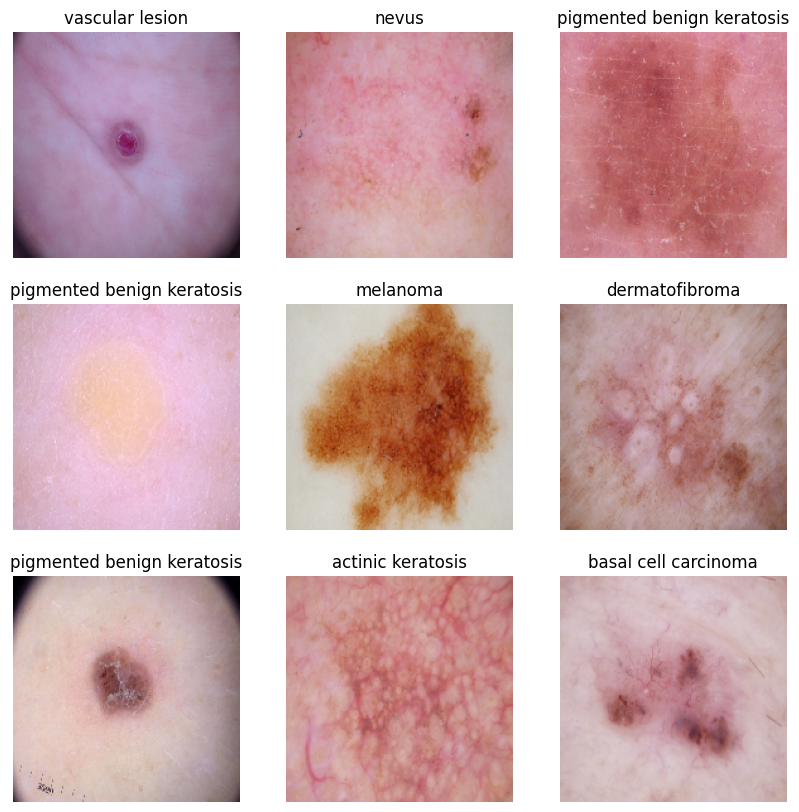

In [122]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [123]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the baseline model
#### Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [124]:
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

num_classes = len(class_names)

baseline_model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

0.044486467 0.90053356


#### Compile the model

In [125]:
baseline_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [126]:
# View the summary of all layers
baseline_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_9 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 45, 45, 64)       

#### Train the model

In [127]:
epochs = 20
history = baseline_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 6s 103ms/step - loss: 2.0812 - accuracy: 0.2349 - val_loss: 1.9463 - val_accuracy: 0.2774
Epoch 2/20
56/56 [==============================] - 5s 93ms/step - loss: 1.8359 - accuracy: 0.3426 - val_loss: 1.7107 - val_accuracy: 0.3244
Epoch 3/20
56/56 [==============================] - 5s 92ms/step - loss: 1.5288 - accuracy: 0.4676 - val_loss: 1.7240 - val_accuracy: 0.3624
Epoch 4/20
56/56 [==============================] - 5s 92ms/step - loss: 1.4472 - accuracy: 0.4682 - val_loss: 1.3937 - val_accuracy: 0.5570
Epoch 5/20
56/56 [==============================] - 5s 93ms/step - loss: 1.2800 - accuracy: 0.5368 - val_loss: 1.4684 - val_accuracy: 0.5414
Epoch 6/20
56/56 [==============================] - 5s 92ms/step - loss: 1.2331 - accuracy: 0.5597 - val_loss: 1.4155 - val_accuracy: 0.5280
Epoch 7/20
56/56 [==============================] - 5s 92ms/step - loss: 1.1497 - accuracy: 0.5971 - val_loss: 1.3861 - val_accuracy: 0.5369
Epoch 8/20
5

##### Visualizing training results

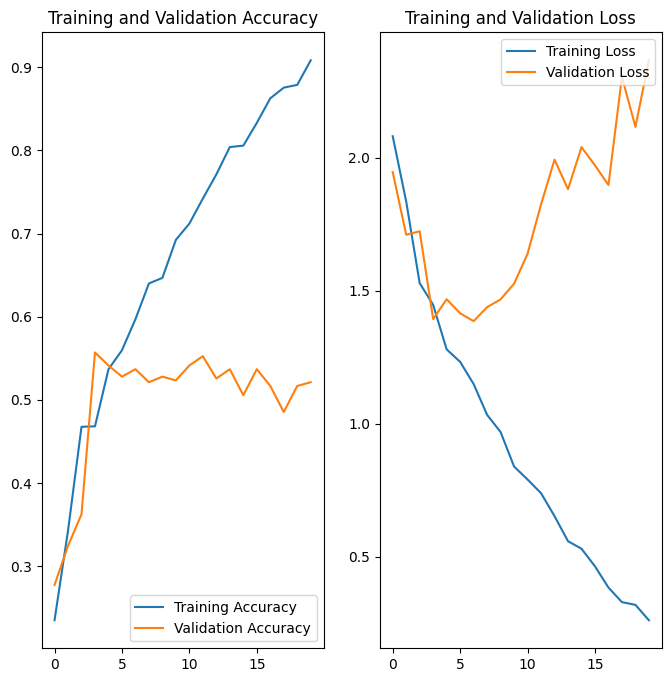

In [128]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### The plot shows that there are large gap between training accuracy and validation accuracy, the highest accuracy achieved by the validation is 55%, instead the training accuracy reach 100% 
#### ==> The model is overfitting. We can enhance the model performance by using data augmentation and drop out layer

### Enhance the model
#### Data Augmentaion

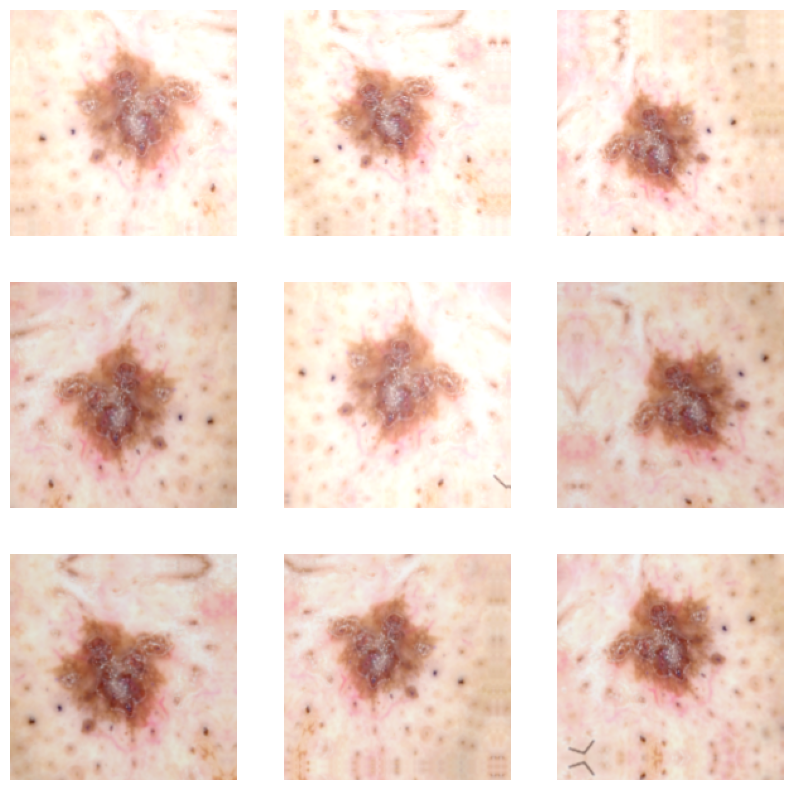

In [129]:
# There are small numbers of sample in training set data, so cause the overfitting in the model. We can enhance the dataset by applying some data augmentation
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),  # Add RandomContrast augmentation
    layers.RandomBrightness(0.1),  # Add RandomBrightness augmentation  
    layers.GaussianNoise(0.1),  # Add GaussianNoise augmentation
    layers.RandomTranslation(0.1, 0.1)
  ]
)

# Visualize the image after apply the data augmentation 

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

#### Create the model, compile and train the model


In [130]:
## Apply some Dropout layer to prevent the overfitting in training model
enhance_model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2), # Adding dropout 20%
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])



#### Compiling the model

In [131]:
enhance_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

enhance_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_10 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 90, 90, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                                

#### Training the model

In [132]:
## Your code goes here, note: train your model for 20 epochs
history = enhance_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=20
)

Epoch 1/20
56/56 [==============================] - 7s 117ms/step - loss: 2.1716 - accuracy: 0.2048 - val_loss: 2.0239 - val_accuracy: 0.1946
Epoch 2/20
56/56 [==============================] - 7s 117ms/step - loss: 1.8915 - accuracy: 0.3064 - val_loss: 1.6976 - val_accuracy: 0.3803
Epoch 3/20
56/56 [==============================] - 7s 116ms/step - loss: 1.6370 - accuracy: 0.4235 - val_loss: 1.5539 - val_accuracy: 0.4564
Epoch 4/20
56/56 [==============================] - 7s 117ms/step - loss: 1.5184 - accuracy: 0.4598 - val_loss: 1.4702 - val_accuracy: 0.4989
Epoch 5/20
56/56 [==============================] - 7s 117ms/step - loss: 1.4347 - accuracy: 0.4883 - val_loss: 1.4626 - val_accuracy: 0.5011
Epoch 6/20
56/56 [==============================] - 7s 118ms/step - loss: 1.4119 - accuracy: 0.5067 - val_loss: 1.4114 - val_accuracy: 0.5145
Epoch 7/20
56/56 [==============================] - 6s 116ms/step - loss: 1.4160 - accuracy: 0.4972 - val_loss: 1.3954 - val_accuracy: 0.5034
Epoch 

#### Visualizing the results

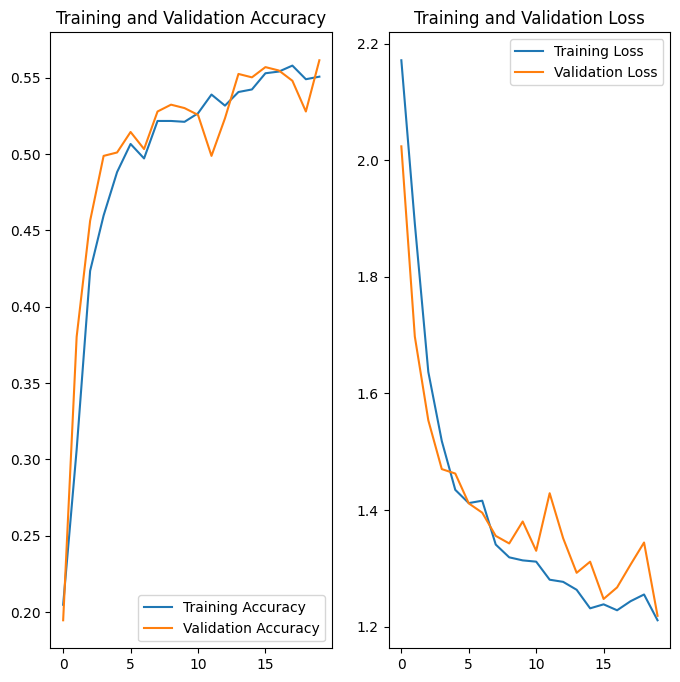

In [133]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##### Conclusion: 
<b>==> After applying the data augmentation and dropout layer, it seems the model is normal now. But the model seems not so good in performance (55% accuracy), maybe we should analyze the training dataset, especially the label distribution</b>

#### Distribution of classes in the training dataset.
**Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

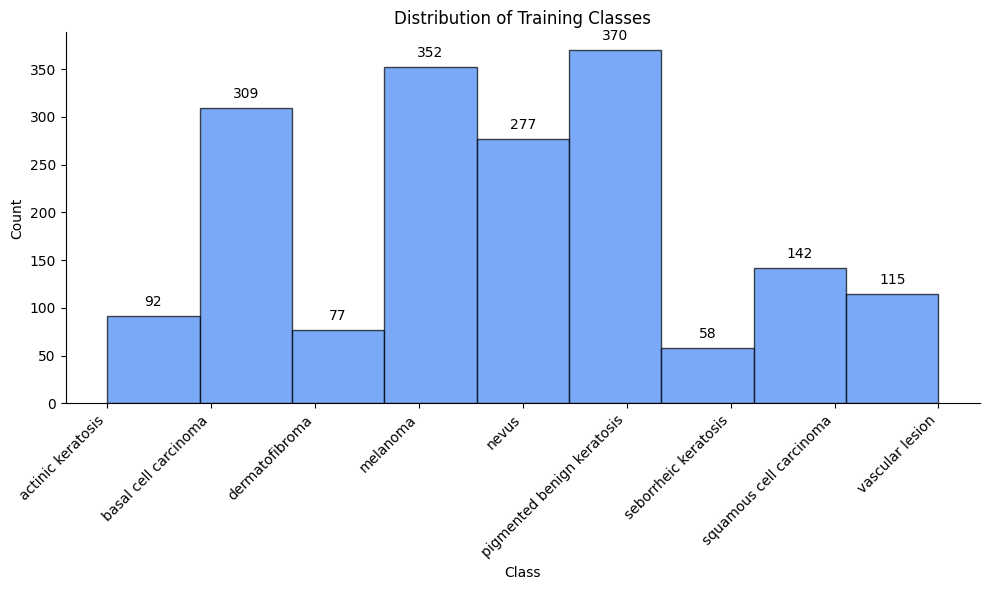

In [134]:
# Get the class names from the directory structure
class_names = class_names
# Get the labels for each batch in the dataset
labels = []
for _, label_batch in train_ds:
    labels.extend(label_batch.numpy())

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the histogram
n, bins, patches = ax.hist(labels, bins=len(class_names), color='#4287f5', alpha=0.7, edgecolor='black')

# Customize the appearance of the histogram
ax.set_xticks(np.arange(len(class_names)))
ax.set_xticklabels(class_names, rotation=45, ha='right')
ax.set_xlabel('Class')
ax.set_ylabel('Count')
ax.set_title('Distribution of Training Classes')

# Add labels to the bars
for i in range(len(patches)):
    ax.annotate(f'{int(n[i])}', xy=(patches[i].get_x() + patches[i].get_width() / 2, patches[i].get_height()),
                xytext=(0, 5), textcoords='offset points', ha='center', va='bottom')

# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

##### Conclusion:

Based on the distribution, we had:
- There are 3 classes have the very few numbers versus the others (actinic, dermato, seborr)
- There are 3 classes that have a lot of samples vs others (basl, melanoma, pigmented)

To help the model improve the performance, we should solve this class imbalanced problem"


### Class Imbalanced

**Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [135]:
!pip3 install Augmentor

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [136]:
# path_to_training_dataset="./dataset/Train/"
path_to_training_dataset = train_dir
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to ./dataset/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1092563A0>: 100%|██████████| 500/500 [00:01<00:00, 488.39 Samples/s]


Initialised with 376 image(s) found.
Output directory set to ./dataset/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x10929AA30>: 100%|██████████| 500/500 [00:01<00:00, 482.57 Samples/s]                  


Initialised with 95 image(s) found.
Output directory set to ./dataset/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x10922ABB0>: 100%|██████████| 500/500 [00:01<00:00, 486.81 Samples/s]


Initialised with 438 image(s) found.
Output directory set to ./dataset/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=679x566 at 0x1092A7970>: 100%|██████████| 500/500 [00:04<00:00, 106.01 Samples/s]  


Initialised with 357 image(s) found.
Output directory set to ./dataset/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x28DA05DF0>: 100%|██████████| 500/500 [00:05<00:00, 98.82 Samples/s]                     


Initialised with 462 image(s) found.
Output directory set to ./dataset/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x10928ED30>: 100%|██████████| 500/500 [00:01<00:00, 484.23 Samples/s]


Initialised with 77 image(s) found.
Output directory set to ./dataset/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x28D9D8130>: 100%|██████████| 500/500 [00:02<00:00, 217.07 Samples/s]                  


Initialised with 181 image(s) found.
Output directory set to ./dataset/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x28D98B220>: 100%|██████████| 500/500 [00:01<00:00, 473.61 Samples/s]                  


Initialised with 139 image(s) found.
Output directory set to ./dataset/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x109180130>: 100%|██████████| 500/500 [00:01<00:00, 440.22 Samples/s]                  


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [137]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

0


#### Lets see the distribution of augmented data after adding new images to the original training data.

In [138]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

[]

In [139]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

[]

In [140]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [141]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [142]:
new_df['Label'].value_counts()

Series([], Name: count, dtype: int64)

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [143]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [144]:
data_dir_train = path_to_training_dataset

In [145]:
# data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 24739 files belonging to 9 classes.
Using 19792 files for training.


#### Create a validation dataset

In [146]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 24739 files belonging to 9 classes.
Using 4947 files for validation.


#### Create your model (make sure to include normalization)

In [147]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

## Apply some Dropout layer to prevent the overfitting in training model
final_model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2), # Adding dropout 20%
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

2023-07-12 22:22:20.725038: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 276 of 1000
2023-07-12 22:22:30.722102: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 557 of 1000
2023-07-12 22:22:33.116602: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


#### Compile your model (Choose optimizer and loss function appropriately)

In [148]:
final_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

final_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_12 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 90, 90, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                                

#### Train your model

In [149]:
epochs = 30
history = final_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
619/619 [==============================] - 78s 126ms/step - loss: 1.6355 - accuracy: 0.3615 - val_loss: 1.3628 - val_accuracy: 0.4710
Epoch 2/30
619/619 [==============================] - 73s 118ms/step - loss: 1.3625 - accuracy: 0.4712 - val_loss: 1.1917 - val_accuracy: 0.5288
Epoch 3/30
619/619 [==============================] - 73s 117ms/step - loss: 1.2652 - accuracy: 0.5089 - val_loss: 1.1182 - val_accuracy: 0.5630
Epoch 4/30
619/619 [==============================] - 75s 121ms/step - loss: 1.1898 - accuracy: 0.5395 - val_loss: 1.0326 - val_accuracy: 0.5989
Epoch 5/30
619/619 [==============================] - 76s 123ms/step - loss: 1.1205 - accuracy: 0.5685 - val_loss: 1.0029 - val_accuracy: 0.6214
Epoch 6/30
619/619 [==============================] - 77s 124ms/step - loss: 1.0909 - accuracy: 0.5762 - val_loss: 0.9043 - val_accuracy: 0.6646
Epoch 7/30
619/619 [==============================] - 76s 123ms/step - loss: 1.0372 - accuracy: 0.6006 - val_loss: 0.8607 - val_ac

#### Visualize the model results

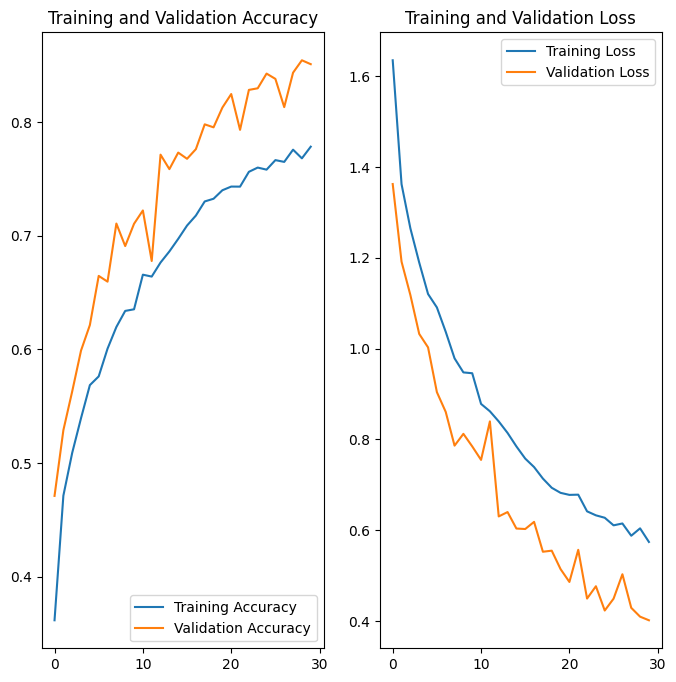

In [150]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

##### Conclusion
As the plot represented, after we solve the imbalanced class problem and apply with the Data Augmentation + Drop Out layer. Now the model performance significant improved, which climb up to 70% in both validation and training set

### Evaluation with the test dataset

In [155]:
test_df = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  seed=123,
  # validation_split = 0.2,
  # subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size
  )

test_df = test_df.cache().prefetch(buffer_size=AUTOTUNE)

# Use the model to predict the class probabilities for each test image
predictions_baseline_model = baseline_model.predict(test_df)
predictions_enhance_model = enhance_model.predict(test_df)
predictions_final_model = final_model.predict(test_df)

# Convert the class probabilities to class labels
predicted_baseline_labels = np.argmax(predictions_baseline_model, axis=1)
predicted_enhance_labels = np.argmax(predictions_enhance_model, axis=1)
predicted_final_labels = np.argmax(predictions_final_model, axis=1)


# Get the true labels from the test dataset
true_labels = []
for _, labels in test_df.map(lambda x, y: (x, y)):
    true_labels.extend(labels.numpy())

# Calculate the accuracy
accuracy_baseline = np.mean(predicted_baseline_labels == true_labels)
accuracy_enhance = np.mean(predicted_enhance_labels == true_labels)
accuracy_final = np.mean(predicted_final_labels == true_labels)
print(f"Accuracy Baseline: {accuracy_baseline * 100}%")
print(f"Accuracy Enhance: {accuracy_enhance * 100}%")
print(f"Accuracy Final: {accuracy_final * 100}%")

Found 118 files belonging to 9 classes.


4/4 [==============================] - 0s 25ms/step
Accuracy Baseline: 33.89830508474576%
Accuracy Enhance: 39.83050847457627%
Accuracy Final: 42.3728813559322%


### Conclusion:
- We have successfully create the multiclass classification model for the Melanoma Detection problem
- The model baseline encountered the overfitting problems due to limit in training samples and imbalanced classes problem
- The final model not only has good performance in training and validation dataset but also better in test dataset versus the baseline and enhance model